In [96]:
#“I certify that this assignment represents my work. I have not used any unauthorized or unacknowledged assistance 
#or sources in completing it, including free or commercial systems or services offered on the internet.”

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_selection import mutual_info_classif
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_score, recall_score,f1_score
from sklearn.metrics import make_scorer, accuracy_score

import multiprocessing
import re

In [98]:
import pandas as pd

# read data
reviews_df = pd.read_csv('deception_data_converted.txt',sep='\t',encoding='iso-8859-1')
reviews_df.head()

,lie,sentiment,review
0,fake,negative,"'Mike\'s Pizza High Point, NY Service was very..."
1,fake,negative,'i really like this buffet restaurant in Marsh...
2,fake,negative,"'After I went shopping with some of my friend,..."
3,fake,negative,'Olive Oil Garden was very disappointing. I ex...
4,fake,negative,'The Seven Heaven restaurant was never known f...


In [99]:
reviews_df.shape

(92, 3)

In [100]:
reviews_df['lie'].value_counts()

fake    46
true    46
Name: lie, dtype: int64

In [101]:
reviews_df['sentiment'].value_counts()

negative    46
positive    46
Name: sentiment, dtype: int64

In [102]:
import arff
arff.dump('product_review.arff'
       , reviews_df.values
       , relation='relation name'
       , names=reviews_df.columns)

In [103]:
# we don't include stem
def text_process(document, rebuild_document=True):
    import re
    words = []
    
    for sentence in sent_tokenize(document):
        tokens = [wordnet_lemmatizer.lemmatize(t.lower())
        for t in regexp_tokenizer.tokenize(sentence) if t.lower() not in stop_words]
        words += tokens

    if rebuild_document:
        #### rebuild the sentence
        content = ' '.join(words).strip()

        content = content.replace(r"'"," ")
        content = re.sub('s\+', ' ', content)
        content = content.strip()
        
        return content
    else:
        return words

In [104]:

reviews_categories = {
    'true': 0,
    'fake': 1}

reviews_X = []
token_reviews_X = []
reviews_Y = []

In [105]:
# load stop-words
stop_words = set(stopwords.words('english'))

# initialize tokenizer
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# initialize stemmer
porter_stemmer = PorterStemmer()

In [106]:
for index, row in reviews_df.iterrows():
    category = row.lie
    text = row.review

    category_idx = reviews_categories[category]

    reviews_X.append(text_process(text))
    token_reviews_X.append(text_process(text,False))
    reviews_Y.append(category_idx)

In [107]:
##LIE DETECTION USING TF-IDF
tf_idf_vectorizer = TfidfVectorizer()
reviews_X_vec = tf_idf_vectorizer.fit_transform(reviews_X)

In [108]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_X_vec.toarray(), reviews_Y, test_size=0.25, random_state=1)


In [109]:
#Minmax scaler to scale data to 0 to 1 for naive bayes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [110]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs))

Feature 1264: Gain ratio = nan
Feature 423: Gain ratio = nan
Feature 416: Gain ratio = nan
Feature 417: Gain ratio = nan
Feature 418: Gain ratio = nan
Feature 419: Gain ratio = nan
Feature 420: Gain ratio = nan
Feature 421: Gain ratio = nan
Feature 422: Gain ratio = nan
Feature 424: Gain ratio = nan
Feature 414: Gain ratio = nan
Feature 425: Gain ratio = nan
Feature 426: Gain ratio = nan
Feature 427: Gain ratio = nan
Feature 428: Gain ratio = nan


/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_25851/3696085333.py:7: RuntimeWarning: divide by zero encountered in log2
  split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))
/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_25851/3696085333.py:7: RuntimeWarning: invalid value encountered in multiply
  split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))
/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_25851/3696085333.py:7: RuntimeWarning: invalid value encountered in divide
  split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))
/var/folders/t0/mwd450_d17x_24_r5z4fl90m0000gn/T/ipykernel_25851/3696085333.py:8: RuntimeWarning: invalid value encountered in double_scalars
  gain_ratios.append((mutual_info[i]/feature_en

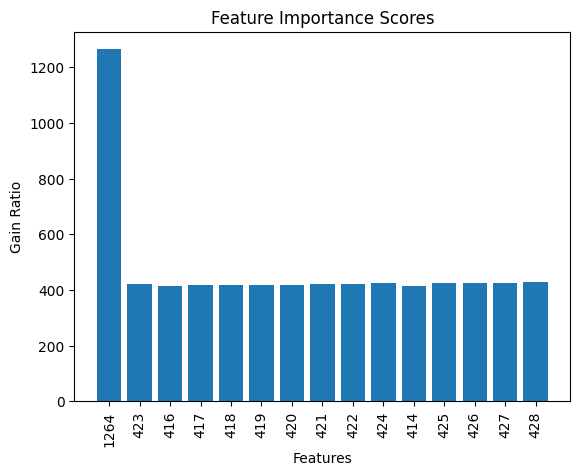

In [111]:
#General GainRatio
mutual_info = mutual_info_classif(X_train_scaled, Y_train)
total_entropy = entropy(Y_train)
gain_ratios = []
for i in range(X_train_scaled.shape[1]):
    feature_entropy = entropy(X_train_scaled[:,i])
    split_information = -np.sum(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])*np.log2(X_train_scaled[:,i]/np.sum(X_train_scaled[:,i])))
    gain_ratios.append((mutual_info[i]/feature_entropy)/split_information)

# print the gain ratios for top 15 features
top_features_idx = np.argsort(gain_ratios)[::-1][:15]
for idx in top_features_idx:
    print(f"Feature {idx}: Gain ratio = {gain_ratios[idx]}")

plt.bar(range(len(top_features_idx)), top_features_idx)
plt.xticks(range(len(top_features_idx)), top_features_idx, rotation=90)
plt.title("Feature Importance Scores")
plt.xlabel("Features")
plt.ylabel("Gain Ratio")
plt.show()

In [112]:
#Vanilla Multinomial
model = MultinomialNB()
model.fit(X_train_scaled, Y_train)
y_pred=model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))


accuracy: 0.391304347826087
F1 score: 0.39015151515151514


In [113]:
#Multinomial NB
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.001, 0.002,0.003,0.004,0.005,0.01, 0.09,0.05, 0.75, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
print("Parameter grid:\n{}".format(param_grid))

mnb_grid_search = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=10,scoring="roc_auc",n_jobs=multiprocessing.cpu_count(),verbose=1)
mnb_grid_search.fit(X_train_scaled, Y_train)

mnb_best = mnb_grid_search.best_estimator_
mnb_best.fit(X_train_scaled,Y_train)
print('Best model: %s' % str(mnb_grid_search.best_params_))
print('Best score: %f' % mnb_grid_search.best_score_)
print('Best test auc: %f' % mnb_best.score(X_test_scaled,Y_test))

y_pred = mnb_best.predict(X_test_scaled)
y_prob = mnb_best.predict_proba(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)


Parameter grid:
{'alpha': [0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.09, 0.05, 0.75, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best model: {'alpha': 0.003}
Best score: 0.600000
Best test auc: 0.347826
accuracy: 0.34782608695652173
F1 score: 0.34782608695652173
Accuracy: 0.34782608695652173


In [114]:
from sklearn.feature_selection import SelectKBest, chi2,f_classif,mutual_info_classif
selector = SelectKBest(f_classif, k=15)

X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
mnb_best.fit(X_train_new,Y_train)
y_pred = mnb_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  54   76  190  260  303  380  444  461  527  605  700  766  875 1034
 1153]
accuracy: 0.43478260869565216
F1 score: 0.35698924731182796
Accuracy: 0.43478260869565216
              precision    recall  f1-score   support

           0       1.00      0.07      0.13        14
           1       0.41      1.00      0.58         9

    accuracy                           0.43        23
   macro avg       0.70      0.54      0.36        23
weighted avg       0.77      0.43      0.31        23



absolutely: 0.27
abruptly: 0.20
aforementioned: 0.20
ad: 0.10
across: 0.09
adorable: 0.08
abc: 0.05
acceptable: 0.05
acknowledge: 0.05
actual: 0.05
actually: 0.05
additional: 0.05
affordable: 0.05
accord: 0.03
add: 0.00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


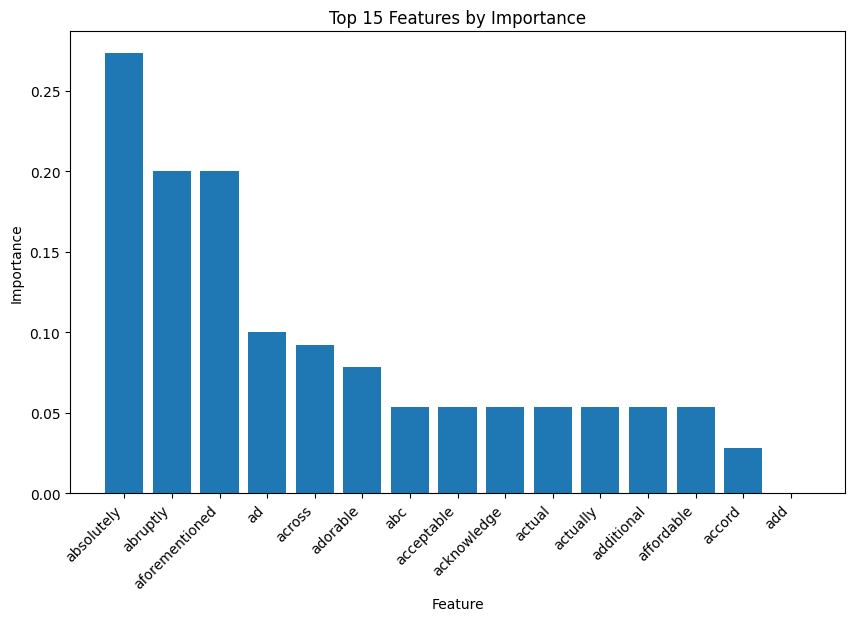

In [115]:
feat_probs = np.exp(mnb_best.feature_log_prob_)

# Get the vocabulary (list of words) from the vectorizer
vocab = tf_idf_vectorizer.get_feature_names()

# Compute the feature importance as the difference in probabilities between the two classes
importance = np.abs(feat_probs[0] - feat_probs[1])

# Combine the feature importance and vocabulary into a dictionary
feat_imp_dict = dict(zip(vocab, importance))

# Sort the dictionary by the feature importance (in descending order)
sorted_feats = sorted(feat_imp_dict, key=feat_imp_dict.get, reverse=True)

# Print the top 15 features and their importance
for feat in sorted_feats[:15]:
    print(f'{feat}: {feat_imp_dict[feat]:.2f}')
    
# Create a bar graph of the top 15 features and their importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feats[:15], [feat_imp_dict[feat] for feat in sorted_feats[:15]])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Features by Importance')
plt.show()

In [116]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.07      0.13        14
           1       0.41      1.00      0.58         9

    accuracy                           0.43        23
   macro avg       0.70      0.54      0.36        23
weighted avg       0.77      0.43      0.31        23



In [117]:
#standardscaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [118]:
#Vanilla SVC
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.43478260869565216
F1 score: 0.35698924731182796


In [119]:
from sklearn.svm import SVC

param_grid = {
    'kernel': ['linear','rbf','poly'],
    'C': [0.1,1,2,3,4,5,10,20,30,40,50,60,70,100],
    'gamma': [0.1, 0.01, 0.001,1,10]
}
print("Parameter grid:\n{}".format(param_grid))
svc_vec_gs = GridSearchCV(estimator=SVC() , param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

svc_vec_gs.fit(X_train_scaled, Y_train)

svc_vec_best = svc_vec_gs.best_estimator_
svc_vec_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(svc_vec_gs.best_params_))
print('Best score: %f' % svc_vec_gs.best_score_)
print('Best test auc: %f' % svc_vec_best.score(X_test_scaled,Y_test))

y_pred = svc_vec_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'kernel': ['linear', 'rbf', 'poly'], 'C': [0.1, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 100], 'gamma': [0.1, 0.01, 0.001, 1, 10]}
Fitting 10 folds for each of 210 candidates, totalling 2100 fits
Best model: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 0.722222
Best test auc: 0.347826
accuracy: 0.34782608695652173
F1 score: 0.3274853801169591
Accuracy: 0.34782608695652173


In [120]:
from sklearn.feature_selection import SelectKBest, chi2,f_classif,mutual_info_classif
selector = SelectKBest(f_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
svc_vec_best.fit(X_train_new,Y_train)
y_pred = svc_vec_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  38  520  523  546  574  672  677  727  786  820  956 1147 1148 1176
 1205]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Top 15 features:
abc: 0.000
abruptly: 0.000
acknowledge: 0.000
across: 0.000
adorable: 0.000
add: 0.000
actually: 0.000
additional: 0.000
aforementioned: 0.085
accord: 0.138
actual: 0.239
affordable: 0.239
absolutely: 0.239
acceptable: 0.239
ad: 0.239


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


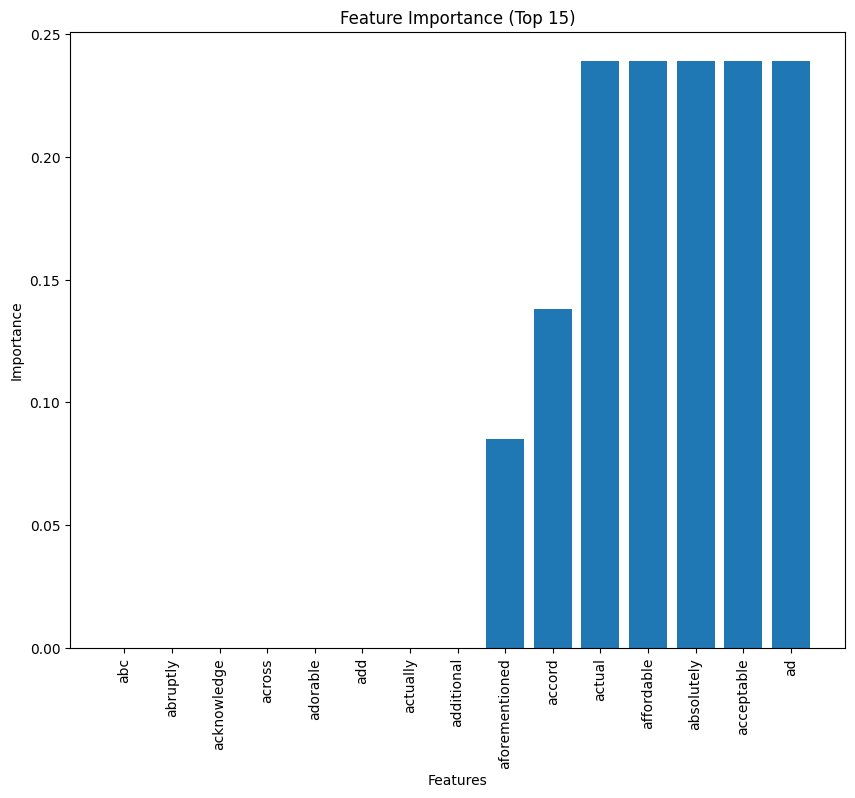

In [121]:
#Feature importance using SVM
svm_weights = np.abs(svc_vec_best.coef_[0])
top_features = np.argsort(svm_weights)[-15:]
print("Top 15 features:")
feature_names = tf_idf_vectorizer.get_feature_names()
for i in top_features:
    print(f"{feature_names[i]}: {svm_weights[i]:.3f}")

plt.figure(figsize=(10, 8))
plt.bar(range(len(top_features)), svm_weights[top_features])
plt.xticks(range(len(top_features)), [feature_names[i] for i in top_features], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Top 15)")
plt.show()

In [122]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [123]:
#Vanilla random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.391304347826087
F1 score: 0.28125


In [124]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,5,7,9],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_samples_split': [15, 20, 30]
}
print("Parameter grid:\n{}".format(param_grid))
random_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

random_gs.fit(X_train_scaled, Y_train)

random_best = random_gs.best_estimator_
random_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(random_gs.best_params_))
print('Best score: %f' % random_gs.best_score_)
print('Best test auc: %f' % random_best.score(X_test_scaled,Y_test))

y_pred = random_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'bootstrap': [True, False], 'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [10, 20, 30, 50], 'min_samples_split': [15, 20, 30]}
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best model: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 20}
Best score: 0.686111
Best test auc: 0.391304
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
from sklearn.feature_selection import SelectKBest, chi2,f_classif,mutual_info_classif
selector = SelectKBest(f_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
random_best.fit(X_train_new,Y_train)
y_pred = random_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[   9   95  139  152  314  365  719  746  785  853  929 1116 1144 1172
 1199]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Top 15 features:
abc: 0.000
abruptly: 0.000
absolutely: 0.000
acceptable: 0.000
accord: 0.000
acknowledge: 0.000
across: 0.000
actual: 0.000
actually: 0.000
ad: 0.000
add: 0.000
additional: 0.000
adorable: 0.000
affordable: 0.000
aforementioned: 1.000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


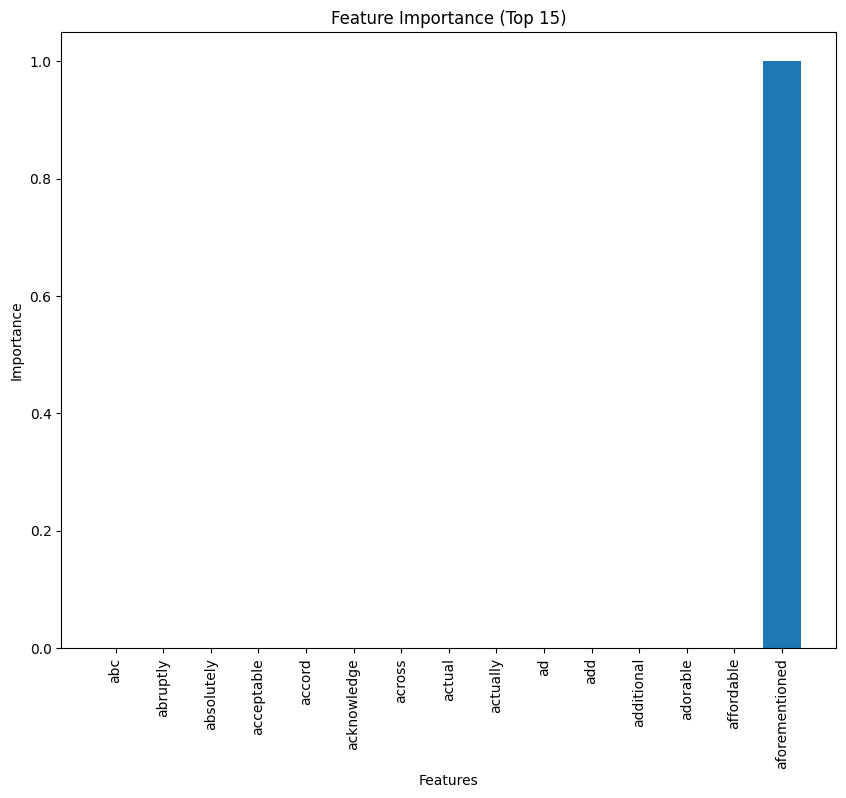

In [126]:
#Feature importance for random forest classifier
rf_importances = random_best.feature_importances_
top_features = np.argsort(rf_importances)[-15:]
print("Top 15 features:")
feature_names = tf_idf_vectorizer.get_feature_names()
for i in top_features:
    print(f"{feature_names[i]}: {rf_importances[i]:.3f}")

# Plot the feature importances for the top 15 features
plt.figure(figsize=(10, 8))
plt.bar(range(len(top_features)), rf_importances[top_features])
plt.xticks(range(len(top_features)), [feature_names[i] for i in top_features], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Top 15)")
plt.show()


In [127]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.39      1.00      0.56         9

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [166]:
##SENTIMENT DETECTION USING tf_idf_VECTORIZER
reviews_categories = {
    'negative': 0,
    'positive': 1}

reviews_X = []
token_reviews_X = []
reviews_Y = []

In [167]:
# load stop-words
stop_words = set(stopwords.words('english'))

# initialize tokenizer
regexp_tokenizer = RegexpTokenizer('[\'a-zA-Z]+')

# initialize lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# initialize stemmer
porter_stemmer = PorterStemmer()

In [168]:
for index, row in reviews_df.iterrows():
    category = row.sentiment
    text = row.review

    category_idx = reviews_categories[category]

    reviews_X.append(text_process(text))
    token_reviews_X.append(text_process(text,False))
    reviews_Y.append(category_idx)

In [169]:
###SENTIMENT DETECTION USING TF-IDF

tf_idf_vectorizer = TfidfVectorizer()
reviews_X_vec = tf_idf_vectorizer.fit_transform(reviews_X)

In [170]:
X_train, X_test, Y_train, Y_test = train_test_split(reviews_X_vec.toarray(), reviews_Y, test_size=0.25, random_state=1)

In [171]:
#Minmax scaler to scale data to 0 to 1 for naive bayes
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [172]:
#Vanilla Multinomial
model = MultinomialNB()
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))


accuracy: 0.8695652173913043
F1 score: 0.8654970760233919


In [173]:
#Multinomial NB
from sklearn.naive_bayes import MultinomialNB

param_grid = {'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
print("Parameter grid:\n{}".format(param_grid))

mnb_grid_search = GridSearchCV(MultinomialNB(), param_grid=param_grid, cv=10,scoring="roc_auc",n_jobs=multiprocessing.cpu_count(),verbose=1)
mnb_grid_search.fit(X_train_scaled, Y_train)

mnb_best = mnb_grid_search.best_estimator_
mnb_best.fit(X_train_scaled,Y_train)
print('Best model: %s' % str(mnb_grid_search.best_params_))
print('Best score: %f' % mnb_grid_search.best_score_)
print('Best test auc: %f' % mnb_best.score(X_test_scaled,Y_test))

y_pred = mnb_best.predict(X_test_scaled)
y_prob = mnb_best.predict_proba(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)


Parameter grid:
{'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best model: {'alpha': 0.2}
Best score: 0.866667
Best test auc: 0.869565
accuracy: 0.8695652173913043
F1 score: 0.8654970760233919
Accuracy: 0.8695652173913043


In [176]:
from sklearn.feature_selection import SelectKBest, chi2,f_classif,mutual_info_classif
selector = SelectKBest(f_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
random_best.fit(X_train_new,Y_train)
y_pred = random_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  28   29   58   79  108  167  228  459  491  695  725  758  935 1110
 1137]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [   2    6    7   12   19   22   32   38   42   43   44   49   55   64
   68   81   85   87   93   94   97   98  101  106  107  112  122  123
  126  127  130  131  133  139  142  146  149  152  157  160  162  166
  168  170  171  178  183  184  188  194  210  211  215  216  225  235
  240  242  247  248  252  254  255  257  259  263  266  270  273  274
  277  325  330  336  339  340  342  347  350  354  355  356  361  366
  377  378  383  391  392  400  405  415  427  440  449  453  455  468
  470  473  476  479  488  496  499  500  501  502  512  513  520  521
  526  535  540  541  543  544  557  561  562  565  566  568  571  578
  580  585  591  592  606  608  611  619  629  646  660  665  666  667
  672  673  676  677  678  680  682  687  696  697  700  702  706  710
  714  715  723  724  736  745  761  774  778  780  792  797 

best: 0.01
amazing: 0.01
great: 0.00
terrible: 0.00
said: 0.00
came: 0.00
minute: 0.00
friendly: 0.00
bad: 0.00
ordered: 0.00
always: 0.00
took: 0.00
really: 0.00
never: 0.00
dine: 0.00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


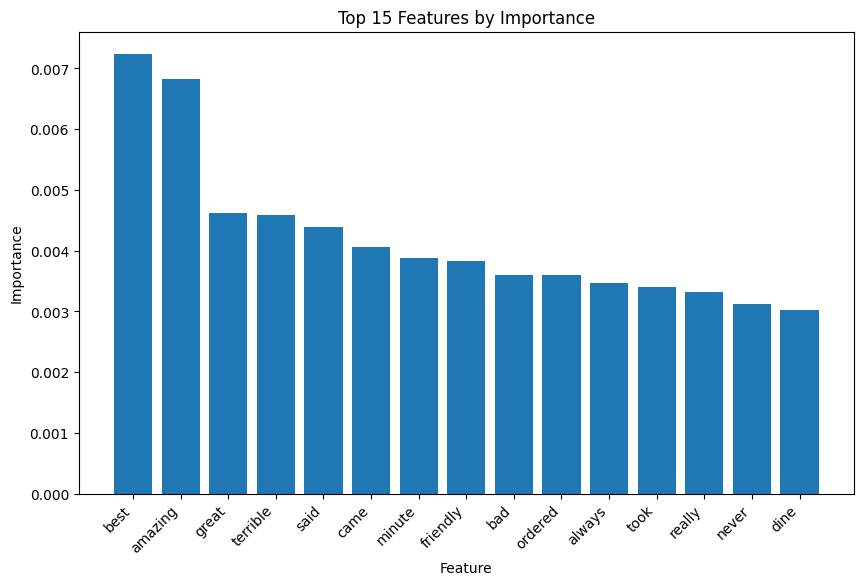

In [137]:
feat_probs = np.exp(mnb_best.feature_log_prob_)

# Get the vocabulary (list of words) from the vectorizer
vocab = tf_idf_vectorizer.get_feature_names()

# Compute the feature importance as the difference in probabilities between the two classes
importance = np.abs(feat_probs[0] - feat_probs[1])

# Combine the feature importance and vocabulary into a dictionary
feat_imp_dict = dict(zip(vocab, importance))

# Sort the dictionary by the feature importance (in descending order)
sorted_feats = sorted(feat_imp_dict, key=feat_imp_dict.get, reverse=True)

# Print the top 15 features and their importance
for feat in sorted_feats[:15]:
    print(f'{feat}: {feat_imp_dict[feat]:.2f}')
    
# Create a bar graph of the top 15 features and their importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_feats[:15], [feat_imp_dict[feat] for feat in sorted_feats[:15]])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Features by Importance')
plt.show()

In [138]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [177]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [178]:
#Vanilla SVC
model = SVC(kernel='linear')
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.391304347826087
F1 score: 0.28125


In [179]:
from sklearn.svm import SVC

param_grid = {
    'kernel': ['linear','rbf'],
    'C': [1,10,20,50,100],
    'gamma': [0.1, 0.01, 0.001]
}
print("Parameter grid:\n{}".format(param_grid))
svc_vec_gs = GridSearchCV(estimator=SVC() , param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

svc_vec_gs.fit(X_train_scaled, Y_train)

svc_vec_best = svc_vec_gs.best_estimator_
svc_vec_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(svc_vec_gs.best_params_))
print('Best score: %f' % svc_vec_gs.best_score_)
print('Best test auc: %f' % svc_vec_best.score(X_test_scaled,Y_test))

y_pred = svc_vec_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'kernel': ['linear', 'rbf'], 'C': [1, 10, 20, 50, 100], 'gamma': [0.1, 0.01, 0.001]}
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best model: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 0.813889
Best test auc: 0.826087
accuracy: 0.8260869565217391
F1 score: 0.7946428571428572
Accuracy: 0.8260869565217391


In [182]:
selector = SelectKBest(f_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
svc_vec_best.fit(X_train_new,Y_train)
y_pred = svc_vec_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[  28   29   58   79  108  167  228  459  491  695  725  758  935 1110
 1137]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [   2    6    7   12   19   22   32   38   42   43   44   49   55   64
   68   81   85   87   93   94   97   98  101  106  107  112  122  123
  126  127  130  131  133  139  142  146  149  152  157  160  162  166
  168  170  171  178  183  184  188  194  210  211  215  216  225  235
  240  242  247  248  252  254  255  257  259  263  266  270  273  274
  277  325  330  336  339  340  342  347  350  354  355  356  361  366
  377  378  383  391  392  400  405  415  427  440  449  453  455  468
  470  473  476  479  488  496  499  500  501  502  512  513  520  521
  526  535  540  541  543  544  557  561  562  565  566  568  571  578
  580  585  591  592  606  608  611  619  629  646  660  665  666  667
  672  673  676  677  678  680  682  687  696  697  700  702  706  710
  714  715  723  724  736  745  761  774  778  780  792  797 

Top 15 features:
absolutely: 0.000
accord: 0.000
across: 0.000
abruptly: 0.000
adorable: 0.000
ad: 0.000
aforementioned: 0.000
acknowledge: 0.000
actual: 0.000
additional: 0.023
affordable: 0.170
actually: 0.239
abc: 0.239
add: 0.239
acceptable: 1.203


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


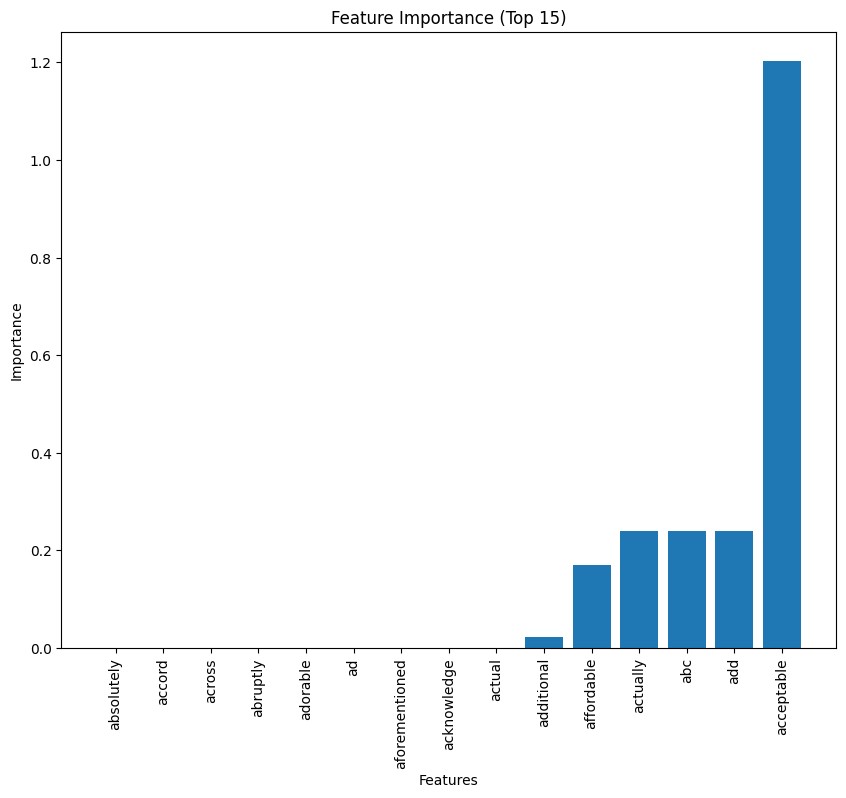

In [143]:
#Feature importance using SVM
svm_weights = np.abs(svc_vec_best.coef_[0])
top_features = np.argsort(svm_weights)[-15:]
print("Top 15 features:")
feature_names = tf_idf_vectorizer.get_feature_names()
for i in top_features:
    print(f"{feature_names[i]}: {svm_weights[i]:.3f}")

plt.figure(figsize=(10, 8))
plt.bar(range(len(top_features)), svm_weights[top_features])
plt.xticks(range(len(top_features)), [feature_names[i] for i in top_features], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Top 15)")
plt.show()

In [144]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [145]:
#Vanilla random forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, Y_train)
model.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))

accuracy: 0.391304347826087
F1 score: 0.28125


In [183]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,5,7,9],
    'min_samples_leaf': [10, 20, 30, 50],
    'min_samples_split': [15, 20, 30]
}
print("Parameter grid:\n{}".format(param_grid))
random_gs = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid ,
        scoring='roc_auc', cv=10, n_jobs=multiprocessing.cpu_count(), verbose=1)

random_gs.fit(X_train_scaled, Y_train)

random_best = random_gs.best_estimator_
random_best.fit(X_train_scaled,Y_train)

print('Best model: %s' % str(random_gs.best_params_))
print('Best score: %f' % random_gs.best_score_)
print('Best test auc: %f' % random_best.score(X_test_scaled,Y_test))

y_pred = random_best.predict(X_test_scaled)
print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)

Parameter grid:
{'bootstrap': [True, False], 'max_depth': [3, 5, 7, 9], 'min_samples_leaf': [10, 20, 30, 50], 'min_samples_split': [15, 20, 30]}
Fitting 10 folds for each of 96 candidates, totalling 960 fits
Best model: {'bootstrap': False, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 15}
Best score: 0.698611
Best test auc: 0.391304
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
selector = SelectKBest(mutual_info_classif, k=15)
X_train_new = selector.fit_transform(X_train_scaled,Y_train)
X_test_new = selector.transform(X_test)
top_features = selector.get_support(indices=True)
print(top_features)
random_best.fit(X_train_new,Y_train)
y_pred = random_best.predict(X_test_new)

print("accuracy:", accuracy_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred,average="macro"))
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')

accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

[ 126  230  285  584  602  835  840  873  875  967 1015 1033 1042 1109
 1155]
accuracy: 0.391304347826087
F1 score: 0.28125
Accuracy: 0.391304347826087
              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

Top 15 features:
abc: 0.000
abruptly: 0.000
acceptable: 0.000
accord: 0.000
acknowledge: 0.000
across: 0.000
actual: 0.000
actually: 0.000
ad: 0.000
add: 0.000
additional: 0.000
aforementioned: 0.000
adorable: 0.316
absolutely: 0.323
affordable: 0.361


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


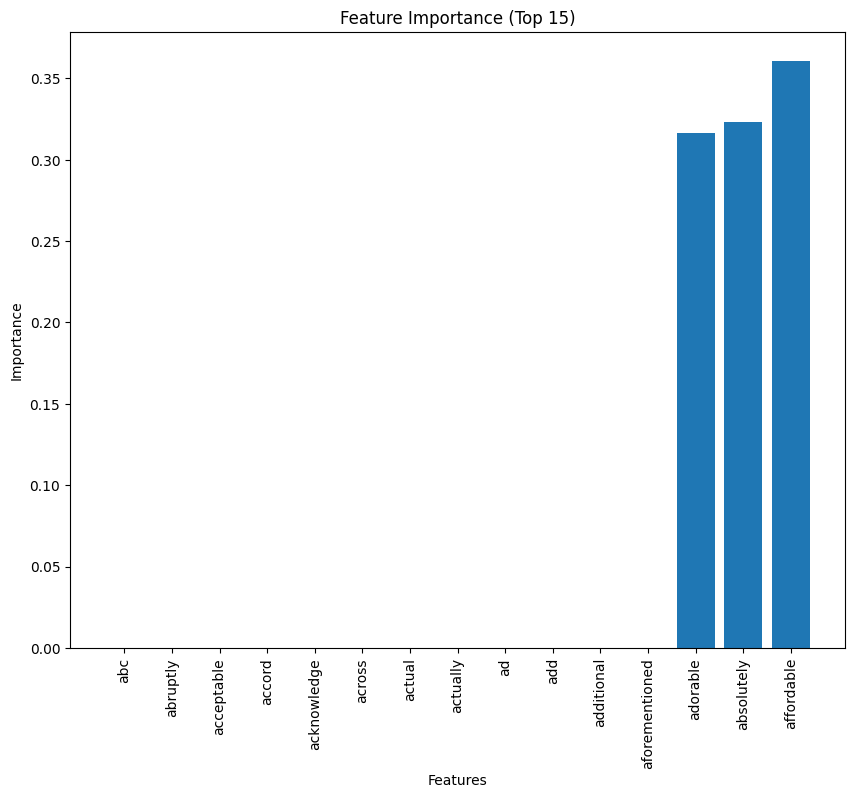

In [148]:
#Feature importance for random forest classifier
rf_importances = random_best.feature_importances_
top_features = np.argsort(rf_importances)[-15:]
print("Top 15 features:")
feature_names = tf_idf_vectorizer.get_feature_names()
for i in top_features:
    print(f"{feature_names[i]}: {rf_importances[i]:.3f}")

# Plot the feature importances for the top 15 features
plt.figure(figsize=(10, 8))
plt.bar(range(len(top_features)), rf_importances[top_features])
plt.xticks(range(len(top_features)), [feature_names[i] for i in top_features], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance (Top 15)")
plt.show()


In [149]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56         9
           1       0.00      0.00      0.00        14

    accuracy                           0.39        23
   macro avg       0.20      0.50      0.28        23
weighted avg       0.15      0.39      0.22        23



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.